In [64]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from utility.get_twitter import *
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
from utility.text_normalizer import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import copy

In [2]:
data = pd.read_csv('../data/all_queries.csv')
data.head()

,date,time,tweet,tweet_id,hashtags,user_id,username,location,num_followers,geo_enabled,long,lat,relevant,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class
0,11/8/21,17:11:01,Defender Radio Live: Canid Response Teams and ...,1.460000e+18,[],9.202440e+08,CoyoteWatchCAN,"Ontario, CA",4420,True,NaN,NaN,0.0,0.000,0.912,0.088,0.2023,positive
1,11/8/21,14:25:52,Yaw 💃💃. Good Morning Twitter Family 🤩✨,1.460000e+18,[],1.460000e+18,coyote_kissa1,"Pasadena, CA",57,False,NaN,NaN,0.0,0.000,0.634,0.366,0.6369,positive
2,11/8/21,12:27:50,"At this moment, I have a neighbor that lives 7...",1.460000e+18,[],1.330000e+18,DavidCMaybury,"Perris, CA",438,True,NaN,NaN,1.0,0.000,0.930,0.070,0.5719,positive
3,11/8/21,10:51:07,@AstroBackyard Had the coyotes barking within ...,1.460000e+18,[],6.883438e+07,darrenreely,"Los Angeles, CA",147,True,NaN,NaN,1.0,0.039,0.912,0.049,0.1511,positive
4,11/8/21,8:28:38,really just saw a coyote cross the street and ...,1.460000e+18,[],2.323440e+09,angeIiques,she/her,109,True,NaN,NaN,1.0,0.256,0.744,0.000,-0.8519,negative


In [112]:
df = data[['tweet', 'relevant']]
df.head()

,tweet,relevant
0,Defender Radio Live: Canid Response Teams and ...,0.0
1,Yaw 💃💃. Good Morning Twitter Family 🤩✨,0.0
2,"At this moment, I have a neighbor that lives 7...",1.0
3,@AstroBackyard Had the coyotes barking within ...,1.0
4,really just saw a coyote cross the street and ...,1.0


In [65]:
model = joblib.load('../bayes_model/best_bayes_pipeline.pkl')

In [8]:
model.best_params_

{'bayes__alpha': 1,
 'wordcount__lowercase': True,
 'wordcount__min_df': 2,
 'wordcount__ngram_range': (1, 2),
 'wordcount__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'wordcount__stop_words': 'english',
 'wordcount__strip_accents': 'ascii'}

In [10]:
predic_proba = model.predict_proba(df['tweet'])

/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [13]:
df['proba_0'] = predic_proba[:,0]
df['proba_1'] = predic_proba[:,1]

<ipython-input-13-5e1b6530cf6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proba_0'] = predic_proba[:,0]
<ipython-input-13-5e1b6530cf6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proba_1'] = predic_proba[:,1]


In [15]:
df.head()

,tweet,relevant,proba_0,proba_1
0,Defender Radio Live: Canid Response Teams and ...,0.0,0.887770,0.112230
1,Yaw 💃💃. Good Morning Twitter Family 🤩✨,0.0,0.641706,0.358294
2,"At this moment, I have a neighbor that lives 7...",1.0,0.035002,0.964998
3,@AstroBackyard Had the coyotes barking within ...,1.0,0.547319,0.452681
4,really just saw a coyote cross the street and ...,1.0,0.047740,0.952260


In [16]:
df_train = df[(df['proba_0'] > 0.85) | (df['proba_1'] > 0.85)]
df_train.shape

(1795, 4)

In [18]:
df_train

,tweet,relevant,proba_0,proba_1
0,Defender Radio Live: Canid Response Teams and ...,0.0,0.887770,0.112230
2,"At this moment, I have a neighbor that lives 7...",1.0,0.035002,0.964998
4,really just saw a coyote cross the street and ...,1.0,0.047740,0.952260
7,To make it worse no one else saw the coyote bruh,1.0,0.949047,0.050953
8,my enemy the big coyote ran in front of my car...,1.0,0.023555,0.976445
...,...,...,...,...
3594,FUCK !! I just hit a coyote,1.0,0.141424,0.858576
3595,I can't stop imagining this help. The Hounds o...,0.0,0.888760,0.111240
3596,@jwrife I can’t have chickens. Too many predat...,0.0,0.853605,0.146395
3599,Potential locations for the antics of Wild E. ...,0.0,0.951907,0.048093


In [20]:
df_train.to_csv('../data/training_data_01.csv', index=None)

In [21]:
df_train = pd.read_csv('../data/training_data_01.csv')
df_train.head()

,tweet,relevant,proba_0,proba_1
0,Defender Radio Live: Canid Response Teams and ...,0.0,0.887770,0.112230
1,"At this moment, I have a neighbor that lives 7...",1.0,0.035002,0.964998
2,really just saw a coyote cross the street and ...,1.0,0.047740,0.952260
3,To make it worse no one else saw the coyote bruh,1.0,0.949047,0.050953
4,my enemy the big coyote ran in front of my car...,1.0,0.023555,0.976445


In [22]:
X = df_train['tweet']
y = df_train['relevant']

# Split data

In [23]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=.4, stratify=None)
X_train.shape, X_val_test.shape, y_train.shape, y_val_test.shape

((1077,), (718,), (1077,), (718,))

In [24]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5, stratify=None)
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((359,), (359,), (359,), (359,))

In [25]:
# Check dim of training, validation, and test sets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1077,), (1077,), (359,), (359,), (359,), (359,))

In [27]:
# Percent of y == 1
y_train[y_train==1].sum() / len(y_train), y_val[y_val==1].sum() / len(y_val), y_test[y_test==1].sum() / len(y_test)

(0.19405756731662024, 0.22284122562674094, 0.1894150417827298)

# Metric Support Function

In [28]:
def print_scores(model, y_true, X_val):
    y_hat = model.predict_proba(X_val)[:,1]
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    print(f'Log Loss: {log_loss(y_true, y_hat):.5f}')
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

In [99]:
def get_log_loss(model, y_true, X):
    y_hat = model.predict_proba(X)[:,1]
    return np.round(log_loss(y_true, y_hat), 4)

In [53]:
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [67]:
model1 = copy.deepcopy(model.best_estimator_)
model2 = copy.deepcopy(model.best_estimator_)
model1 == model2

False

In [68]:
model1.fit(X_train, y_train)

/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Pipeline(steps=[('wordcount',
                 CountVectorizer(min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f949b49c310>,
                                 stop_words='english', strip_accents='ascii')),
                ('bayes', MultinomialNB(alpha=1))])

              precision    recall  f1-score   support

  irrelevant       0.98      0.92      0.95       279
    relevant       0.78      0.95      0.86        80

    accuracy                           0.93       359
   macro avg       0.88      0.94      0.91       359
weighted avg       0.94      0.93      0.93       359

Log Loss: 0.31453


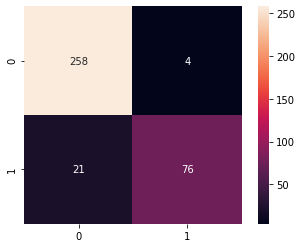

In [69]:
print_scores(model1, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       0.99      0.96      0.98       279
    relevant       0.89      0.96      0.92        80

    accuracy                           0.96       359
   macro avg       0.94      0.96      0.95       359
weighted avg       0.97      0.96      0.96       359

Log Loss: 0.15155


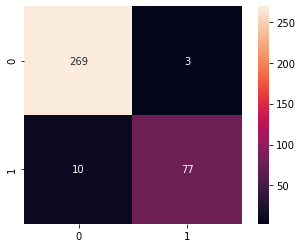

In [71]:
print_scores(model2, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       1.00      0.94      0.97       291
    relevant       0.80      0.99      0.88        68

    accuracy                           0.95       359
   macro avg       0.90      0.96      0.92       359
weighted avg       0.96      0.95      0.95       359

Log Loss: 0.19124


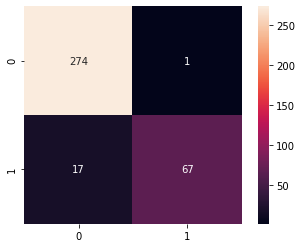

In [73]:
print_scores(model2, y_test, X_test)

### Note:

We can't compare our new model to the old model because the new training data is labeled with the old model. We can only use this data to compare new models

# Modeling

In [80]:
model.best_params_

{'bayes__alpha': 1,
 'wordcount__lowercase': True,
 'wordcount__min_df': 2,
 'wordcount__ngram_range': (1, 2),
 'wordcount__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'wordcount__stop_words': 'english',
 'wordcount__strip_accents': 'ascii'}

# CV and NB

In [89]:
cv = CountVectorizer(lowercase=True, min_df=2, ngram_range=(1,2), preprocessor=tweet_preprocessor, stop_words='english', strip_accents='ascii')
nb = MultinomialNB()
pipeline = Pipeline([('cv', cv), ('nb', nb)])
params = {
    'nb__alpha': [5, 7, 10, 20]
}
search = GridSearchCV(pipeline, param_grid=params, scoring='neg_log_loss', cv=3, verbose=50, n_jobs=-1)

In [90]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(min_df=2,
                                                        ngram_range=(1, 2),
                                                        preprocessor=<function tweet_preprocessor at 0x7f949b49c310>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1, param_grid={'nb__alpha': [5, 7, 10, 20]},
             scoring='neg_log_loss', verbose=50)

In [91]:
search.best_params_

{'nb__alpha': 5}

In [92]:
cvnb = search.best_estimator_

              precision    recall  f1-score   support

  irrelevant       0.97      0.97      0.97       279
    relevant       0.90      0.91      0.91        80

    accuracy                           0.96       359
   macro avg       0.94      0.94      0.94       359
weighted avg       0.96      0.96      0.96       359

Log Loss: 0.17488


(None, 0.1749)

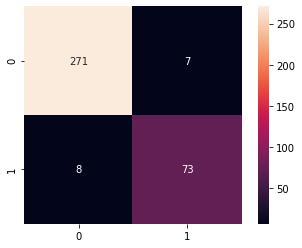

In [100]:
print_scores(cvnb, y_val, X_val), get_log_loss(cvnb, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       0.98      0.92      0.95       279
    relevant       0.78      0.95      0.86        80

    accuracy                           0.93       359
   macro avg       0.88      0.94      0.91       359
weighted avg       0.94      0.93      0.93       359

Log Loss: 0.31453


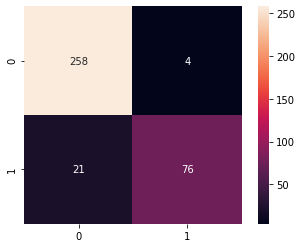

In [94]:
print_scores(model1, y_val, X_val)

# CV SVM

In [166]:
svc = SVC(probability=True, class_weight='balanced')
pipeline = Pipeline([('cv', cv), ('svc', svc)])
params = {
    'svc__C': np.linspace(.7, 1.3, 3),
    'svc__kernel': ['sigmoid']
}
search = GridSearchCV(pipeline, param_grid=params, verbose=50, scoring='neg_log_loss', n_jobs=-1, cv=3)

In [167]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(min_df=2,
                                                        ngram_range=(1, 2),
                                                        preprocessor=<function tweet_preprocessor at 0x7f949b49c310>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': array([0.7, 1. , 1.3]),
                         'svc__kernel': ['sigmoid']},
             scoring='neg_log_loss', verbose=50)

In [168]:
search.best_params_

{'svc__C': 1.0, 'svc__kernel': 'sigmoid'}

In [169]:
search.best_score_

-0.1152211675082326

In [170]:
vcsvc = search.best_estimator_

              precision    recall  f1-score   support

  irrelevant       0.97      0.96      0.97       279
    relevant       0.87      0.91      0.89        80

    accuracy                           0.95       359
   macro avg       0.92      0.94      0.93       359
weighted avg       0.95      0.95      0.95       359

Log Loss: 0.20058


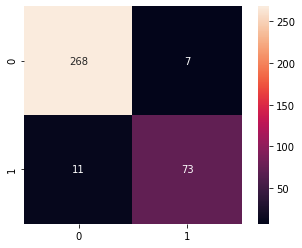

In [171]:
print_scores(vcsvc, y_val, X_val)

# TFIDF and NB

In [145]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='ascii', lowercase=True, max_df=2, min_df=2, preprocessor=tweet_preprocessor, stop_words='english')
nb = MultinomialNB()
pipeline = Pipeline([('tfidf', tfidf), ('nb', nb)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(.5, 5, 4)
}
search = GridSearchCV(pipeline, param_grid=params, cv=3, verbose=50, n_jobs=-1, scoring='neg_log_loss')

In [146]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=2, min_df=2,
                                                        preprocessor=<function tweet_preprocessor at 0x7f949b49c310>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': array([0.5, 2. , 3.5, 5. ]),
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='neg_log_loss', verbose=50)

In [147]:
search.best_params_

{'nb__alpha': 0.5, 'tfidf__ngram_range': (1, 2)}

In [148]:
search.best_score_

-0.425723379687494

In [149]:
tfidfnb = search.best_estimator_

              precision    recall  f1-score   support

  irrelevant       0.83      0.97      0.89       279
    relevant       0.72      0.29      0.41        80

    accuracy                           0.82       359
   macro avg       0.77      0.63      0.65       359
weighted avg       0.80      0.82      0.78       359

Log Loss: 0.45973


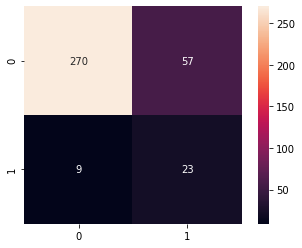

In [150]:
print_scores(tfidfnb, y_val, X_val)

# TFIDF and SVM

In [151]:
pipeline = Pipeline([('tfidf', tfidf), ('svc', svc)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svc__C': np.linspace(.5, 5, 5)
}
search = GridSearchCV(pipeline, param_grid=params, cv=3, verbose=50, n_jobs=-1, scoring='neg_log_loss')

In [152]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=2, min_df=2,
                                                        preprocessor=<function tweet_preprocessor at 0x7f949b49c310>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': array([0.5  , 1.625, 2.75 , 3.875, 5.   ]),
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='neg_log_loss', verbose=50)

In [153]:
search.best_score_

-0.4496956888216727

In [154]:
search.best_params_

{'svc__C': 0.5, 'tfidf__ngram_range': (1, 2)}

In [155]:
tfidfsvc = search.best_estimator_

              precision    recall  f1-score   support

  irrelevant       0.86      0.91      0.88       279
    relevant       0.61      0.46      0.52        80

    accuracy                           0.81       359
   macro avg       0.73      0.69      0.70       359
weighted avg       0.80      0.81      0.80       359

Log Loss: 0.48749


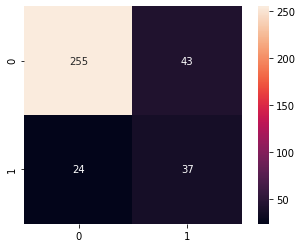

In [158]:
print_scores(tfidfsvc, y_val, X_val)

In [172]:
print('CountVector and NB log loss =', get_log_loss(cvnb, y_val, X_val))
print('CountVector and SVC log loss =', get_log_loss(vcsvc, y_val, X_val))

CountVector and NB log loss = 0.1749
CountVector and SVC log loss = 0.2006


Final model is CountVector and NB

              precision    recall  f1-score   support

  irrelevant       0.98      0.97      0.97       291
    relevant       0.86      0.91      0.89        68

    accuracy                           0.96       359
   macro avg       0.92      0.94      0.93       359
weighted avg       0.96      0.96      0.96       359

Log Loss: 0.15288


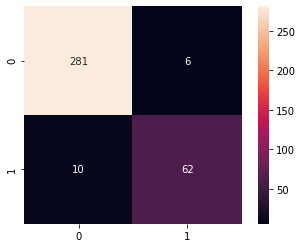

In [173]:
print_scores(cvnb, y_test, X_test)

# Look at top 2 models and compare using Cross Validation, K=10

### Define new train and test sets because using cross validation now

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [205]:
from sklearn.model_selection import cross_val_predict

In [206]:
cvnb_y_hat = cross_val_predict(cvnb, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')
vcsvc_y_hat = cross_val_predict(vcsvc, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

In [220]:
cvnb_ll = log_loss(y_train, cvnb_y_hat[:,1])
vcsvc_ll = log_loss(y_train, vcsvc_y_hat[:,1])

In [221]:
print('cv -> nb log loss =', cvnb_ll)
print('cv -> svc log loss =', vcsvc_ll)

cv -> nb log loss = 0.13839045344612705
cv -> svc log loss = 0.11666129225455779


### Final model is CV and SVC

Test on test set

              precision    recall  f1-score   support

  irrelevant       0.99      0.96      0.98       365
    relevant       0.85      0.95      0.90        84

    accuracy                           0.96       449
   macro avg       0.92      0.96      0.94       449
weighted avg       0.96      0.96      0.96       449

Log Loss: 0.10483


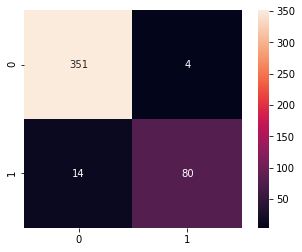

In [222]:
print_scores(vcsvc, y_test, X_test)

In [211]:
import joblib

In [212]:
with open('../bayes_model/best_bayes_model_01.pkl', 'wb') as f:
    joblib.dump(vcsvc, f)

In [213]:
m = joblib.load('../bayes_model/best_bayes_model_01.pkl')

In [218]:
text = ['I saw a coyote eating a dog', 'Go Coyotes!', 'When do you think well see another coyote?', 'At home yesterday I saw a coyote hiding in the bush', 'Was driving and almost ran over a coyote...', 'Swear, I heard coyotes in my backyard. My dog was barking like nuts!']

In [219]:
m.predict(text)

array([1., 0., 1., 0., 1., 1.])

# Need to check how to compare this model to the old model

In [223]:
old_model = joblib.load('../bayes_model/cvsvc_01.pkl')

              precision    recall  f1-score   support

  irrelevant       0.97      0.94      0.96       365
    relevant       0.78      0.87      0.82        84

    accuracy                           0.93       449
   macro avg       0.87      0.91      0.89       449
weighted avg       0.93      0.93      0.93       449

Log Loss: 0.23442


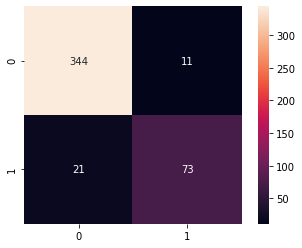

In [225]:
print_scores(old_model, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.99      0.96      0.98       365
    relevant       0.85      0.95      0.90        84

    accuracy                           0.96       449
   macro avg       0.92      0.96      0.94       449
weighted avg       0.96      0.96      0.96       449

Log Loss: 0.10483


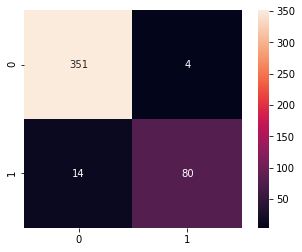

In [226]:
print_scores(vcsvc, y_test, X_test)

The new models performs better